In [ ]:
import gensim
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sps
import pickle
import yfinance as yf
import statsmodels.api as sm
import math

from tqdm import tqdm
from gensim.models import KeyedVectors
from datetime import datetime

sns.set_style("whitegrid")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_test = pd.read_pickle("/content/drive/MyDrive/ML_EPFL_Project/data/ts_data/test_ts.pkl")
snp500 = pd.read_csv("/content/drive/MyDrive/ML_EPFL_Project/data/market.csv")
stocks = pd.read_csv('/content/drive/MyDrive/ML_EPFL_Project/data/stocks.csv')
stocks.loc[:, 'Date'] = pd.to_datetime(stocks['Date'], format='%Y-%m-%d')
snp500['Date'] = snp500['Date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d")).astype(object)

df_test.head()

,date,exchange,q,ticker,transcript,daily_r,weekly_r,monthly_r
10601,2021-11-02 00:00:00,NASDAQ: ZYXI,2021-Q3,ZYXI,prepared remark operator good day welcome zyne...,-0.030977,0.134234,-0.249404
10602,2021-11-02 00:00:00,NYSE: COUR,2021-Q3,COUR,prepared remark operator lady gentleman thank ...,-0.023762,-0.029137,-0.280905
10603,2021-11-02 00:00:00,NASDAQ: OTTR,2021-Q3,OTTR,prepared remark operator good morning welcome ...,-0.007384,0.053417,0.060644
10604,2021-11-02 00:00:00,NYSE: AYX,2021-Q3,AYX,prepared remark operator greeting welcome alte...,-0.006112,-0.011959,-0.174196
10605,2021-11-02 00:00:00,NYSE: RAMP,2022-Q2,RAMP,prepared remark operator good afternoon lady g...,0.032662,-0.034295,-0.144257


In [ ]:
index = stocks[['Date']]

In [ ]:
def add_trade(cur_row, strategy, holding_period):
    start_dt = cur_row['date']
    ticker = cur_row['ticker']
    coef = cur_row['alpha']
    msk = (index['Date'] >= start_dt)

    for i in range(0, holding_period):
        cur_date = index[msk]['Date'].iloc[i]
        if coef > 0:
            strategy.loc[cur_date, 'long'][ticker] = coef

        elif coef < 0:
            strategy.loc[cur_date, 'short'][ticker] = -coef


def get_weights(cur_day):
    coefs_l = cur_day['long']
    coefs_s = cur_day['short']

    if len(coefs_l) + len(coefs_s) == 0:
        return pd.Series({"weight": {}})

    companies = [x for x in coefs_l] + [x for x in coefs_s]
    alpha_pos = sum([coefs_l[x] for x in coefs_l])
    alpha_neg = sum([coefs_s[x] for x in coefs_s])
    ss = alpha_pos + alpha_neg

    coefs = {}

    for tick in coefs_l:
        coefs[tick] =  coefs_l[tick] / ss

    for tick in coefs_s:
        coefs[tick] =  -coefs_s[tick] / ss

    return pd.Series({"weight": coefs})


def run_strategy(X_0, strategy):
    portfolio_value = [X_0]
    num_stocks = []
    change_stocks = []
    added_value = []
    delta = []
    returns = []

    t = 0

    for t in tqdm(range(0, strategy.shape[0])):
        cur_r = strategy.iloc[t]
        X_cur = portfolio_value[-1]
        cur_c = cur_r['weight']

        if len(cur_c) == 0:
            portfolio_value.append(X_cur)
            num_stocks.append({})
            change_stocks.append({})
            added_value.append({})
            delta.append(0)
            returns.append(0)

            continue

        cur_st_pr = stocks[stocks['Date'] == cur_r.name]
        cur_w = {x: int(cur_c[x] * X_cur / cur_st_pr[x].item())  for x in cur_c}
        value = sum([abs(cur_w[st]) * cur_st_pr[st].item() for st in cur_c])

        if value > X_cur:
          print("\nError", t)
          print("Value:", value, "X_cur:",  X_cur, "Delta:", X_cur - value)
          print("----------")

        next_st_pr = stocks[stocks['Date'] == strategy.iloc[t+1].name]
        delta_W = sum([cur_w[st] * (next_st_pr[st].item() - cur_st_pr[st].item()) for st in cur_c])

        portfolio_value.append(X_cur + delta_W)
        num_stocks.append(cur_w)
        change_stocks.append({st: next_st_pr[st].item() - cur_st_pr[st].item() for st in cur_c})
        added_value.append({st: cur_w[st] * (next_st_pr[st].item() - cur_st_pr[st].item()) for st in cur_c})
        delta.append(delta_W)
        returns.append(delta_W / X_cur)


    pnl = pd.DataFrame({
      "date": index['Date'],
      "value": portfolio_value[:-1],
      "number_stocks": num_stocks,
      "change_stock": change_stocks,
      "added_value": added_value,
      "delta": delta,
      "return": returns,
    })

    while pnl.iloc[0].value == pnl.iloc[1].value and pnl.iloc[1].value == pnl.iloc[2].value:
        pnl = pnl.iloc[1:]

    while pnl.iloc[-1].value == pnl.iloc[-2].value and pnl.iloc[-3].value == pnl.iloc[-2].value:
        pnl = pnl.iloc[:-1]

    return pnl


In [ ]:
def get_coefs(path):
    coefs = pd.read_csv(path)
    coefs.set_index('Unnamed: 0', inplace=True)
    coefs.rename(columns={coefs.columns[0]: 'alpha'}, inplace=True)

    return coefs


def descr(df):
    st = df.describe()
    for col in st.index.difference(["count"]):
        st.loc[col] = st.loc[col].apply(lambda x: "{0:.2%}".format(x))

    return st


def get_precision(path):
    coefs = pd.read_csv(path)
    coefs.set_index('Unnamed: 0', inplace=True)
    coefs.rename(columns={coefs.columns[0]: 'alpha'}, inplace=True)

    df_strategy = df_test.merge(coefs, how='left', left_index=True, right_index=True)
    df_strategy['trd'] = df_strategy['weekly_r'].apply(lambda x: np.abs(x) > 0.04)
    need_to_trade = df_strategy['trd'].sum()
    actual_trade = sum(df_strategy[df_strategy.trd == True].alpha != 0)
    recall = actual_trade / need_to_trade


    df_strategy['trade'] = df_strategy['alpha'] != 0
    df_strategy['match'] = (df_strategy['alpha'] * df_strategy['weekly_r']) > 0

    traded = df_strategy[df_strategy['trade'] == True]
    precision = traded['match'].sum() / traded['trade'].sum()

    return precision, recall


def get_alpha_stats(pnl_res, title, path):
    df = pd.merge(pnl_res, snp500, left_on='date', right_on='Date')

    rf_annual = 0.04
    rf_daily = (1 + rf_annual) ** (1 / 252) - 1

    x = df['ret_mar'] - rf_daily
    rets = df[['Date', 'return']].copy()
    rets.set_index('Date', inplace=True)
    w_rets = (1 + rets).resample('W').prod() - 1
    y_rets = (1 + rets).resample('Y').prod() - 1

    y = df['return'] - rf_daily

    X2 = sm.add_constant(x)
    est = sm.OLS(y, X2)
    est_res = est.fit()
    precision, recall = get_precision(path)

    stats = {
        'title': [title],
        'precision': [precision],
        'recall': [recall],
        'weekly mean': [w_rets.mean().item()],
        'weekly std': [w_rets.std().item()],
        'yearly mean': [y_rets.mean().item()],
        'yearly std': [y_rets.std().item()],
        'SR': [(y_rets.mean().item() - rf_annual) / y_rets.std().item()],
        'alpha': [est_res.params['const']],
        't(alpha)': [est_res.tvalues['const']],
        'beta': [est_res.params['ret_mar']],
        't(beta)': [est_res.tvalues['ret_mar']],
        'F-statistic': [est_res.fvalue],
        'R-squared': [est_res.rsquared],
        # 'AIC': [est_res.aic],
    }
    # 'precision',

    res = pd.DataFrame(stats)
    for col in ['precision', 'recall', 'weekly mean', 'weekly std', 'yearly mean', 'yearly std',
                'alpha', 'R-squared']:
        res[col] = res[col].apply(lambda x: "{0:.2%}".format(x))

    for col in ['t(alpha)', 'SR', 'beta', 't(beta)', 'F-statistic']:
        res[col] = res[col].apply(lambda x: "{0:.2f}".format(x))


    return res

In [ ]:
import scipy.stats as sps

n = 1289
k = 2

sps.t(df=n-k).isf(0.05), sps.f(k-1, n-k).isf(0.05)

(1.646038454643832, 3.8486943420038298)

In [ ]:
def combine_signals(row, colnames):
    cx = colnames[0]
    cy = colnames[1]

    if row[cx] * row[cy] > 0:
        return row[cx] / abs(row[cx])
    return 0


def merge_coefs(path1, path2):
    c0 = get_coefs(path1)
    c1 = get_coefs(path2)
    merged = pd.merge(c0, c1, left_index=True, right_index=True)
    cols = merged.columns
    merged['alpha'] = merged.apply(combine_signals, args=(cols,), axis=1)
    merged.drop(columns=cols, inplace=True)
    return merged


In [ ]:
def get_strtategy(path, holding_pediod=7):
    coefs = pd.read_csv(path)
    coefs.set_index('Unnamed: 0', inplace=True)
    coefs.rename(columns={coefs.columns[0]: 'alpha'}, inplace=True)
    coefs.head()

    strategy = pd.DataFrame({
        "long": {date: {} for date in index.Date},
        "short": {date: {} for date in index.Date},
    })

    df_strategy = df_test[['date', 'ticker']].merge(coefs, how='left', left_index=True, right_index=True)
    df_strategy.apply(add_trade, axis=1, args=(strategy, holding_pediod,))
    strategy = strategy.apply(get_weights, axis=1)
    return strategy


In [ ]:
def get_strategy_results(path, title, X_0 = 10000, ts_dir=''):
    strategy = get_strtategy(path)
    pnl = run_strategy(X_0, strategy)
    res = get_alpha_stats(pnl, title, path)
    res.to_csv('/content/drive/MyDrive/ML_EPFL_Project/Strategies_stats/ts_approach/' + ts_dir + path.split('/')[-1])

    return pnl, res


In [ ]:
total_stats = []

In [ ]:
path = '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/ts_strategies/ts_multi_naive_bayes.csv'

pnl_v0, res_v0 = get_strategy_results(path, 'Naive Bayes')
total_stats.append(res_v0)
res_v0

100%|██████████| 1509/1509 [00:04<00:00, 315.24it/s] 


,title,precision,recall,weekly mean,weekly std,yearly mean,yearly std,SR,alpha,t(alpha),beta,t(beta),F-statistic,R-squared
0,Naive Bayes,49.04%,89.88%,-0.05%,2.84%,-1.82%,8.40%,-0.69,-0.04%,-0.63,-0.40,-8.16,66.61,16.54%


In [ ]:
path = '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/ts_strategies/bert_v2.csv'

pnl_v1, res_v1 = get_strategy_results(path, 'FinBert')
total_stats.append(res_v1)
res_v1

100%|██████████| 1509/1509 [00:00<00:00, 2290.11it/s] 


,title,precision,recall,weekly mean,weekly std,yearly mean,yearly std,SR,alpha,t(alpha),beta,t(beta),F-statistic,R-squared
0,FinBert,59.83%,3.83%,1.14%,5.75%,29.04%,37.89%,0.66,0.25%,1.84,0.53,5.54,30.67,8.48%


In [ ]:
path = '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/ts_strategies/ts_xgb_100features.csv'

pnl_v2, res_v2 = get_strategy_results(path, 'XGBoost 100 features')
total_stats.append(res_v2)
res_v2

100%|██████████| 1509/1509 [00:05<00:00, 282.14it/s] 


,title,precision,recall,weekly mean,weekly std,yearly mean,yearly std,SR,alpha,t(alpha),beta,t(beta),F-statistic,R-squared
0,XGBoost 100 features,56.94%,79.87%,0.85%,2.55%,25.85%,42.73%,0.51,0.16%,2.29,-0.13,-2.64,7.00,2.04%


In [ ]:
path = '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/ts_strategies/ts_cat_100features_50_6.csv'

pnl_v3, res_v3 = get_strategy_results(path, 'CatBoost 100 features')
total_stats.append(res_v3)
res_v3

100%|██████████| 1509/1509 [00:04<00:00, 311.32it/s]  


,title,precision,recall,weekly mean,weekly std,yearly mean,yearly std,SR,alpha,t(alpha),beta,t(beta),F-statistic,R-squared
0,CatBoost 100 features,54.32%,83.67%,0.68%,2.82%,18.15%,27.02%,0.52,0.12%,1.83,-0.08,-1.74,3.02,0.89%


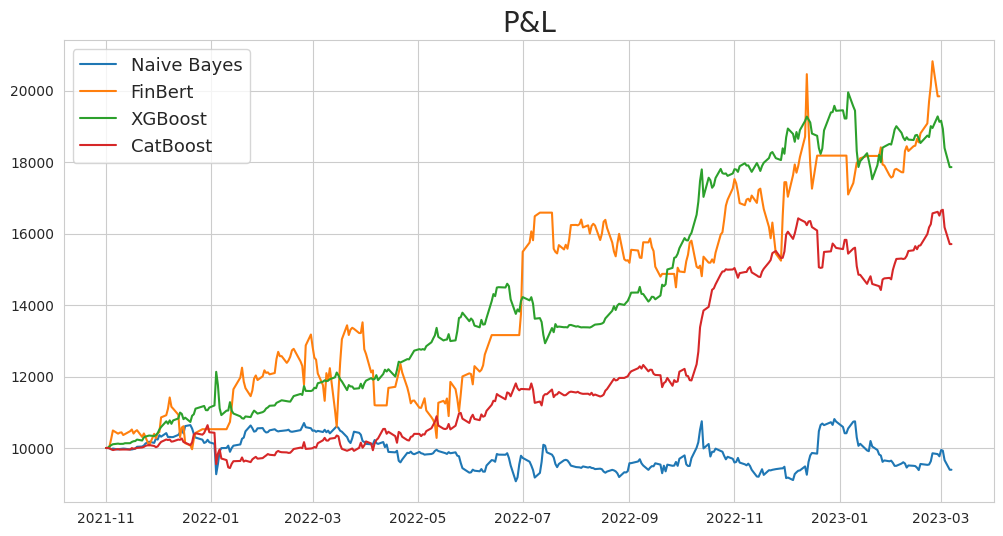

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(pnl_v0['date'], pnl_v0['value'], label='Naive Bayes')
plt.plot(pnl_v1['date'], pnl_v1['value'], label='FinBert')
plt.plot(pnl_v2['date'], pnl_v2['value'], label='XGBoost')
plt.plot(pnl_v3['date'], pnl_v3['value'], label='CatBoost')
plt.title("P&L", fontsize=20)
plt.legend(fontsize=13)
plt.show()

In [ ]:
merged_v0 = merge_coefs(
     '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/ts_strategies/ts_cat_100features_50_6.csv',
    '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/ts_strategies/ts_xgb_100features.csv'
)
merged_v0.to_csv('/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/ts_strategies/CB&XGB.csv')

In [ ]:
path = '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/ts_strategies/CB&XGB.csv'

pnl_v4, res_v4 = get_strategy_results(path, 'Catboost + XGBoost')
total_stats.append(res_v4)
res_v4

100%|██████████| 1509/1509 [00:02<00:00, 571.02it/s] 


,title,precision,recall,weekly mean,weekly std,yearly mean,yearly std,SR,alpha,t(alpha),beta,t(beta),F-statistic,R-squared
0,Catboost + XGBoost,58.60%,48.25%,0.99%,4.37%,33.13%,63.95%,0.46,0.18%,1.72,-0.26,-3.58,12.79,3.67%


In [ ]:
merged_v1 = merge_coefs(
    '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/ts_strategies/bert_v2.csv',
    '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/ts_strategies/ts_cat_100features_50_6.csv',
)
merged_v1.to_csv('/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/ts_strategies/Bert&CB.csv')

In [ ]:
path = '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/ts_strategies/Bert&CB.csv'
pnl_v5, res_v5 = get_strategy_results(path, 'FinBert + CatBoost')
total_stats.append(res_v5)
res_v5

100%|██████████| 1509/1509 [00:00<00:00, 2934.15it/s] 


,title,precision,recall,weekly mean,weekly std,yearly mean,yearly std,SR,alpha,t(alpha),beta,t(beta),F-statistic,R-squared
0,FinBert + CatBoost,63.72%,1.93%,1.80%,6.12%,73.03%,129.76%,0.53,0.38%,2.69,0.40,4.01,16.10,4.64%


In [ ]:
merged_v2 = merge_coefs(
    '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/ts_strategies/bert_v2.csv',
    '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/ts_strategies/ts_xgb_100features.csv'
)
merged_v2.to_csv('/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/ts_strategies/Bert&XGB.csv')

In [ ]:
path = '/content/drive/MyDrive/ML_EPFL_Project/Strategies_coefs/ts_strategies/Bert&XGB.csv'
pnl_v6, res_v6 = get_strategy_results(path, 'FinBert + XGBoost')
total_stats.append(res_v6)
res_v6

100%|██████████| 1509/1509 [00:00<00:00, 2348.57it/s]


,title,precision,recall,weekly mean,weekly std,yearly mean,yearly std,SR,alpha,t(alpha),beta,t(beta),F-statistic,R-squared
0,FinBert + XGBoost,58.97%,1.51%,0.88%,6.36%,17.55%,16.96%,0.80,0.18%,1.15,0.36,3.20,10.21,3.05%


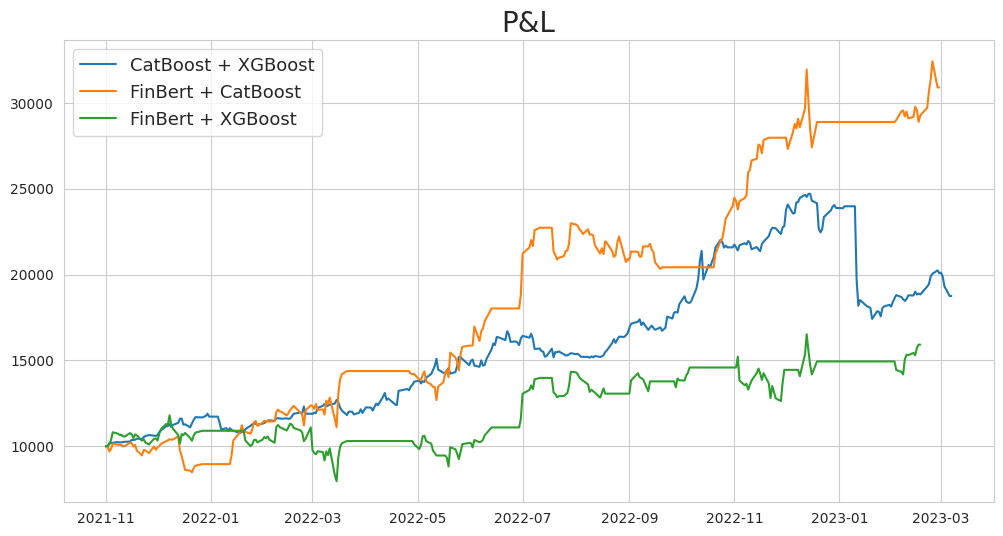

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(pnl_v4['date'], pnl_v4['value'], label='CatBoost + XGBoost')
plt.plot(pnl_v5['date'], pnl_v5['value'], label='FinBert + CatBoost')
plt.plot(pnl_v6['date'], pnl_v6['value'], label='FinBert + XGBoost')
plt.title("P&L", fontsize=20)
plt.legend(fontsize=13)
plt.show()

In [ ]:
res_stats = pd.concat(total_stats).reset_index(drop=True)
res_stats

,title,precision,recall,weekly mean,weekly std,yearly mean,yearly std,SR,alpha,t(alpha),beta,t(beta),F-statistic,R-squared
0,Naive Bayes,49.04%,89.88%,-0.05%,2.84%,-1.82%,8.40%,-0.69,-0.04%,-0.63,-0.40,-8.16,66.61,16.54%
1,FinBert,59.83%,3.83%,1.14%,5.75%,29.04%,37.89%,0.66,0.25%,1.84,0.53,5.54,30.67,8.48%
2,XGBoost 100 features,56.94%,79.87%,0.85%,2.55%,25.85%,42.73%,0.51,0.16%,2.29,-0.13,-2.64,7.00,2.04%
3,CatBoost 100 features,54.32%,83.67%,0.68%,2.82%,18.15%,27.02%,0.52,0.12%,1.83,-0.08,-1.74,3.02,0.89%
4,Catboost + XGBoost,58.60%,48.25%,0.99%,4.37%,33.13%,63.95%,0.46,0.18%,1.72,-0.26,-3.58,12.79,3.67%
5,FinBert + CatBoost,63.72%,1.93%,1.80%,6.12%,73.03%,129.76%,0.53,0.38%,2.69,0.40,4.01,16.10,4.64%
6,FinBert + XGBoost,58.97%,1.51%,0.88%,6.36%,17.55%,16.96%,0.80,0.18%,1.15,0.36,3.20,10.21,3.05%


In [ ]:
res_stats.to_csv('/content/drive/MyDrive/ML_EPFL_Project/stats_ts.csv')

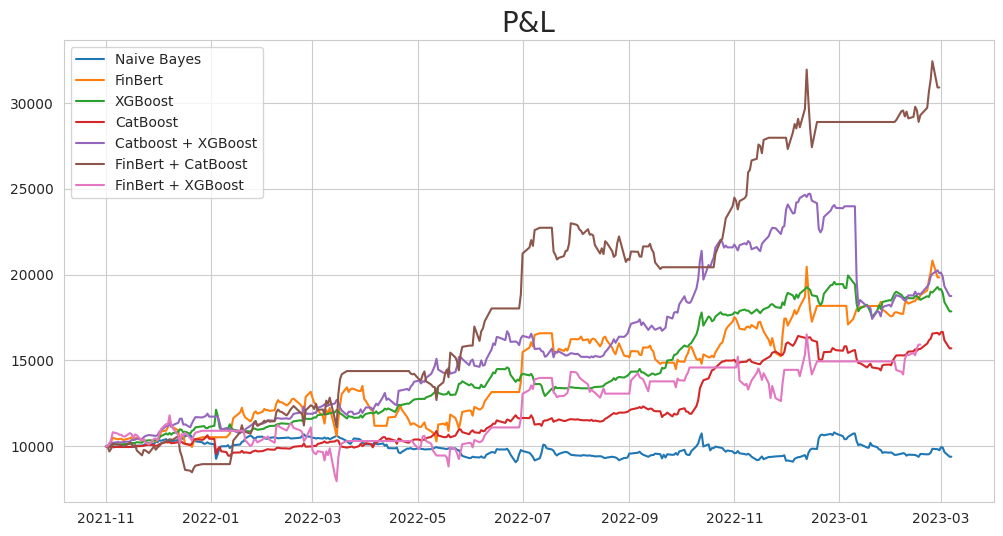

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(pnl_v0['date'], pnl_v0['value'], label='Naive Bayes')
plt.plot(pnl_v1['date'], pnl_v1['value'], label='FinBert')
plt.plot(pnl_v2['date'], pnl_v2['value'], label='XGBoost')
plt.plot(pnl_v3['date'], pnl_v3['value'], label='CatBoost')
plt.plot(pnl_v4['date'], pnl_v4['value'], label='Catboost + XGBoost')
plt.plot(pnl_v5['date'], pnl_v5['value'], label='FinBert + CatBoost')
plt.plot(pnl_v6['date'], pnl_v6['value'], label='FinBert + XGBoost')
plt.title("P&L", fontsize=20)
plt.legend(fontsize=13)
plt.legend()
plt.show()